# FORCAST Grism Spectra: Basic Inspection and Assessment


## Introduction

This recipe provides an overview and sample python code for plotting and assessing FORCAST grism data.  The FORCAST observing modes are described in the SOFIA Observer’s Handbooks, available from the [Proposing and Observing  page on the SOFIA website](https://www.sofia.usra.edu/researchers/proposing-and-observing); and the FORCAST data products are described in the [FORCAST GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf).  

Raw FORCAST data suffers from several instrumental artifacts.  Nearly all of the artifacts are removed or corrected by the  FORCAST pipeline, including: bad pixels; the Droop effect; non-linear pixel response; and the “jailbar” effect.  In addition, the grism pipeline extracts the one-dimensional spectra, applies both wavelength and flux calibration, and corrects for telluric absorption.   For point sources, an "optimal extraction" algorithm is used, while for extended (non-point-like) sources, a standard summation over a fixed aperture is used (see recipe on custom extractions for additional information).  See the [FORCAST GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf) for details regarding the artifacts, pipeline algorithms, and the flux-calibration process.  

Level 3 FORCAST grism data is written in FITS format as a 2-dimensional data array with a single header (for detailed description, see FORCAST GO Data Handbook).  The data is in a 5 x N array, where N is the number of wavelength bins/samples, with the following convention:
-  The first line  of the data array contains the wavelength ($\mu$m);
- the second line  contains the pipeline-reduced and flux calibrated spectrum (Jy); 
- the third line contains the uncertainty (Jy); 
- the fourth  contains the adopted atmospheric transmission spectrum; 
- and the fifth contains the instrumental response used in the flux calibration process (Me-/s/Jy, where "Me-" is 10^6 electrons).

Each FORCAST grism file contains the spectrum for a specific grism, which is indicated in the name of the file, e.g. "FORG111" would be a file containing data for the 11.1 $\mu$m grism.  The pipeline does *not* combine specta from different grisms,  this is left to the user.  

There are two data types for  LEVEL 3 FORCAST grism data:
1.  CAL files:  flux calibrated results for each raw (LEVEL_1) data file. There can be multiple CAL files for a single AOR.
2.  CMB files:  if possible, multiple CAL files for a single AOR are coadded into a "combined" data file.  Usually there is only one CMB file per AOR.

Except for the provenance, the two datatypes are identical and hence the procedures below are equally valid for both.

The "error" spectrum is for the statistical uncertainty *only* and does not reflect systematic uncertainties in the absolute flux, for example losses due to slit misalignment or poor image quality (see below).   If absolute fluxes are required, it is highly recommended that additional imaging data are obtained at the same time in order to calibrate the grism spectra accurately.  

## Ingredients

1. Level 3 (flux calibrated) FORCAST grism data (either CAL or CMB files) from the Infrared Science Archive ([ISRA](https://irsa.ipac.caltech.edu/Missions/sofia.html))
2. Sample Data (if desired):  For the examples in this recipe, we use the calibrated data for AB Aur from program 05_0138 (PI: Shuping), flight 434. The dataset consists of four LEVEL 3 CMB files, one file for each grism setting (G063, G111, G227, and G329), which can be downloaded from the ISRA using the following search parameters:
        - Coordinates or Object Name = AB Aur
        - Radius = 100 arcseconds
        - MissionID = 2017-09-27_FO_F434
        - PlanID = 05_0138
        - Instrument = FORCAST
        - Configuration = Low Resolution Spectroscopy
        - Processing State = LEVEL 3
The four files should be saved with their original names in a folder named "forcast-sample-data" in the same directory as this Python Notebook:
        - forcast-sample-data/F0434_FO_GRI_0501381_FORG063_CMB_0228-0229.fits
        - forcast-sample-data/F0434_FO_GRI_0501382_FORG111_CMB_0234-0238.fits
        - forcast-sample-data/F0434_FO_GRI_0501383_FORG227_CMB_0230-0233.fits
        - forcast-sample-data/F0434_FO_GRI_0501384_FORG329_CMB_0239-0246.fits
  **You can download the example data directly [here](https://zenodo.org/record/5706312/files/FORCAST-Grism_Inspection-example-data.zip?download=1)**.
  

3. [FORCAST GO Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_data_handbook.pdf) for reference (latest version can be found on the [SOFIA Data Products](https://www.sofia.usra.edu/science/proposing-and-observing/data-products) page.)

## Viewing the FITS Header

First we will read a FITS file for one of the grism observations, display the full header, and then pick out some important keyword values to display in a "summary" table.

In [1]:
from astropy.io import fits

#first open the file...
g063_fits = fits.open('F0434_FO_GRI_0501381_FORG063_CMB_0228-0229.fits')
#...and get info
g063_fits.info()

Filename: F0434_FO_GRI_0501381_FORG063_CMB_0228-0229.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     324   (242, 5)   float64   


You can see from the FITS file info that the file contains a single primary HDU with 5 x 242 element array containing the calibrated data.  Now display the full header:

In [2]:
#Now display FITS header in full:
g063_fits[0].header

SIMPLE  =                    T / Written by IDL:  Wed Nov 22 15:43:45 2017      
BITPIX  =                  -64 /Real*8 (double precision)                       
NAXIS   =                    2 /                                                
NAXIS1  =                  242 /                                                
NAXIS2  =                    5 /                                                
ALTI_STA=                42984 / feet, aircraft altitude start das.ic1080_15hz.p
ALTI_END=                42993 / feet, aircraft altitude end das.ic1080_15hz.pre
AOR_ID  = '05_0138_1'          / Astronomical Observation Request Identifier    
ASSC_AOR= '05_0138_1'          / All input AOR-IDs                              
ATRNFILE= 'ATRAN_Models/atran_43K_35deg_4-50mum.sav' / ATRAN file               
CALERR  =            0.0237970 / Fractional flux calibration error              
C2NC2   =                    F / pointing controlled without telescope nod      
CHOPPING=                   

The header is quite large, so we might want to just pull out some keywords of interest:

In [3]:
#And now pull out useful summary data from specific keywords:
keywords = ['ALTI_STA',
    'ALTI_END',
    'AOR_ID ', 
    'CHPAMP1 ',
    'DATE-OBS',
    'MISSN-ID  ',                          
    'NODAMP  ',
    'OBJECT ',
    'SKY_ANGL ',    
    'SKYMODE  ',                      
    'SLIT    ',
    'ZA_START  ',     
    'ZA_END  ',
    'TELVPA  ',
    'NODSTYLE',
    'TOTINT    ',
    'CALQUAL   ',                      
    'WCSQUAL     ',                         
    'DATAQUAL']

#Loop over keywords to print.
for kywd in keywords:
        print(kywd,'=',g063_fits[0].header[kywd],'/',g063_fits[0].header.comments[kywd])

ALTI_STA = 42984 / feet, aircraft altitude start das.ic1080_15hz.p
ALTI_END = 42993 / feet, aircraft altitude end das.ic1080_15hz.pre
AOR_ID  = 05_0138_1 / Astronomical Observation Request Identifier
CHPAMP1  = 30 / arcsec, chop amplitude on sky sma.sky_amplitude
DATE-OBS = 2017-09-27T09:03:58.606 / observation start ccyy-mm-ddThh:mm:ss.s
MISSN-ID   = 2017-09-27_FO_F434 / mission id
NODAMP   = 60 / arcsec nod amplitude
OBJECT  = AB Aur (1) / name given by observer
SKY_ANGL  = 261.527 / "up" on det from N, coords.pos.sibs.vpa
SKYMODE   = NMC / sky patterning mode
SLIT     = FOR_LS47 / slit
ZA_START   = 35.3101 / zenith angle soo 90-coord.pos.sibs.alt
ZA_END   = 34.9659 / zenith angle eoo
TELVPA   = 261.527 / deg, SI VPA coord.pos.sibs_vpa
NODSTYLE = NMC / nod/chop style
TOTINT     = 71.8406 / Total integration time (s) as specified in the
CALQUAL    = NOMINAL / Calibration status
WCSQUAL      = UNKNOWN / WCS validity
DATAQUAL = NOMINAL / QA status: see HISTORY


This list of keywords provides a nice summary of the observation.  There are a few different keywords in the header for integration time(s); here we show TOTINT because it reflects the total on-source integration time (factoring in chop-nod style). This is the value that the GO should use to compare to the FORCAST integration time estimator.  It is also important to take a look at the HISTORY cards to see a summary of the data pipelining and especially the QA notes, which are usually at the end of the HISTORY block:

In [4]:
#Display HISTORY block:
print(g063_fits[0].header['HISTORY'])



Previous History
----------------


Headers updated by dsandel, 2017-09-29T10:40:42
WCSQUAL: None -> UNKNOWN

---------------------------------------
---------- PIPELINE HISTORY -----------
---------------------------------------

:::::::::::::::::::::::::::::::::::::
::: LOAD DATA, CALCULATE VARIANCE :::
Read noise is 244.800
Excess noise factor is 1.00000
Gain is 136.000
Integration time is 8.98005
Variance for raw data calculated from
V = N*betaG/(FR*t*g) + RN^2/(FR*t*g^2), where
N is the raw ADU per frame in each pixel,
betaG is the excess noise factor,
FR is the frame rate, t is the integration time,
g is the gain, and RN is the
read noise in electrons

::::::::::::::::::::::::
::: CLEAN BAD PIXELS :::
Clean: Jailbar cleaning method is MEDIAN
Interpolate using maskinterp(data,mask,1,6,plsfit)
Clean: Remove corrupted line 255 - Replaced with 254

::::::::::::::::::::::::
::: DROOP CORRECTION :::
Droop: Applied channel suppression (droop) correction
Droop: Channel suppression corr

So in this case, manual optimization of the telluric correction failed and the default atran model was used for the reduction.  So the GO might want to examine the G063 data to see if there are issues with the telluric correction in the data.

## Slit Orientation on the Sky

For some observations, it is important to know the slit orientation and geometry on the sky.  The slit width (arcsec), height (arcsec), and long-axis position angle (degrees, E of N) are logged in the keywords SLTW_ARC, SLTH_ARC, and SKY_ANGL, respectively:

In [5]:
#Display keywords related to slit geometry:
slit_keywords = ['SLTW_ARC',
    'SLTH_ARC',                            
    'SKY_ANGL']

#Loop over keywords to print.
for kywd in slit_keywords:
        print(kywd,'=',g063_fits[0].header[kywd],'/',g063_fits[0].header.comments[kywd])

SLTW_ARC = 4.7 / Slit width in arcseconds
SLTH_ARC = 194.3 / Slit height in arcseconds
SKY_ANGL = 261.527 / "up" on det from N, coords.pos.sibs.vpa


We can use the slit information and sky position to create a DS9 region file which can then be imported into DS9 and overplotted on any image of the object with a valid WCS.  Specification for regions in DS9 can be found here:  http://ds9.si.edu/doc/ref/region.html.  Note that either the TELRA/DEC or OBSRA/DEC can be used for the sky position:  TELRA/DEC is the sky position as reported by the telescope at the time of the observation whereas OBSRA/DEC is the sky position specified by the observer in the AOR.  Due to various issues, the TELRA/DEC is not always accurate, especially for chop/nod observations.  We recommend trying both and contacting your instrument scientist if there is a discrepancy.  

In [6]:
#First store the relevant values in local variables, for convenience.
object = g063_fits[0].header['OBJECT']
ra = str(15.0*g063_fits[0].header['OBSRA'])  #converting from hours to degrees
dec = str(g063_fits[0].header['OBSDEC'])
slitw_arc = str(g063_fits[0].header['SLTW_ARC'])
slith_arc = str(g063_fits[0].header['SLTH_ARC'])
sky_angl = str(g063_fits[0].header['SKY_ANGL'])

#now create a regions file and write the values above in according to region file spec:
file = open(object+'_slit.reg', 'w')
file.write('# Region file format: DS9 version 4.1\n')
file.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
file.write('fk5\n')
file.write('box('+ra+'d,'+dec+'d,'+slitw_arc+'\",'+slith_arc+'\",'+sky_angl+') # text = {'+object+'}')
file.close()

To use the region file, first load an image of your target into DS9.  In this example, we will load a WISE image of AB Aur:

![WISE Band 1 Image of AB Aur](figs/ds9_abaur.png)

Then click "Regions" -> "Load Region...", navigate to the local directory where your region file was saved, and click on the region file (in this example: "AB Aur (1) slit.reg").  Format should be "ds9"; the slit size and orientation should then be overplotted on the image:

![WISE Band 1 Image of AB Aur, with slit overlay](figs/ds9_abaur-slit.png)

## Reading the File and Loading the Data into a Table Structure

Now we'll read a FITS file for the grism of interest and load the data into a convenient set of table structures in Python.  We'll start with the G227 (22.7 $\mu$m) grism data.  The file contains a single HDU containing a 5 x 236 array.  Now place the data portion into a separate table structure for convenience:

In [7]:
import numpy as np
from astropy.table import Column
from astropy.table import Table
from astropy import constants as const
from astropy import units as u

#Define a function for loading fits data into tables with units
def loadFORCASTGrismData(filename):
    #Now open fits file for the sample data...
    data_fits = fits.open(filename)

    #... read the data portion of the file into a separate array:
    data_tmp = data_fits[0].data

    #... load into table for convenience:
    data_table = Table([data_tmp[0],data_tmp[1],data_tmp[2],data_tmp[3],data_tmp[4]], 
                  names=('wavelength', 'flux', 'error', 'telluric', 'response'), masked = True,
                  meta={'name': 'Data Table'})

    #...and assign units:
    data_table['wavelength'].unit = 'micron'
    data_table['flux'].unit = 'Jy'
    data_table['error'].unit = 'Jy'
    data_table['response'].unit = '1/(Jy*s)'  #response is (Me-/s)/Jy
    
    #...and mask NaNs in the flux.
    data_table['flux'].mask = np.isnan(data_table['flux'])
    
    return data_fits,data_table  #return both the FITS structure and the table.

#Now read the file for the G227 data:
g227_fits,g227 = loadFORCASTGrismData('F0434_FO_GRI_0501383_FORG227_CMB_0230-0233.fits')

g227.info

<Table masked=True length=236>
   name     dtype     unit    n_bad
---------- ------- ---------- -----
wavelength float64     micron     0
      flux float64         Jy     4
     error float64         Jy     0
  telluric float64                0
  response float64 1 / (Jy s)     0

## Plotting the Spectra

Start by plotting flux (with errors) and S/N as a function of wavelength:

C:\Users\Steven\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


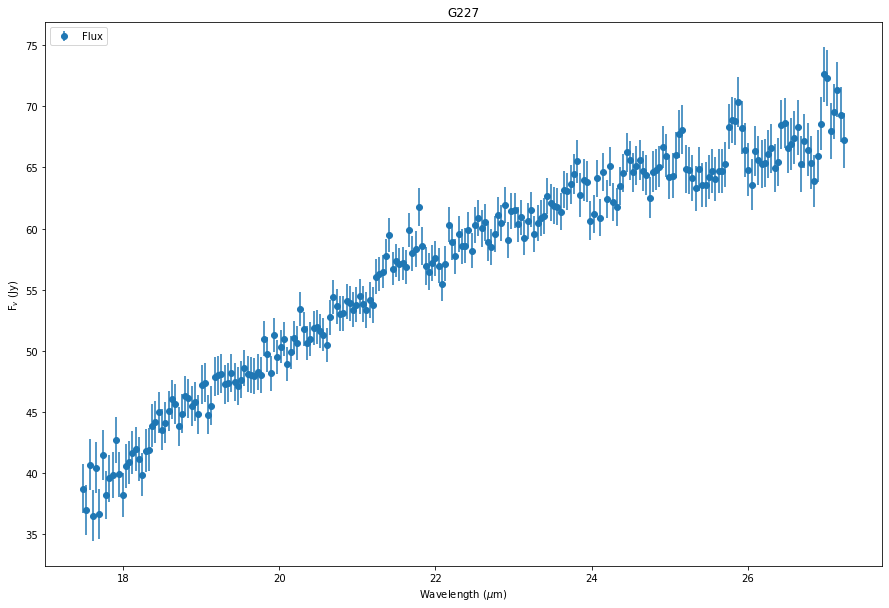

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
# ^leave out if in a non-interactive environment

plt.figure(figsize=(15,10))
plt.errorbar(g227['wavelength'],g227['flux'],yerr=g227['error'],fmt='o', label = 'Flux')

plt.title("G227")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend(loc = 'upper left');

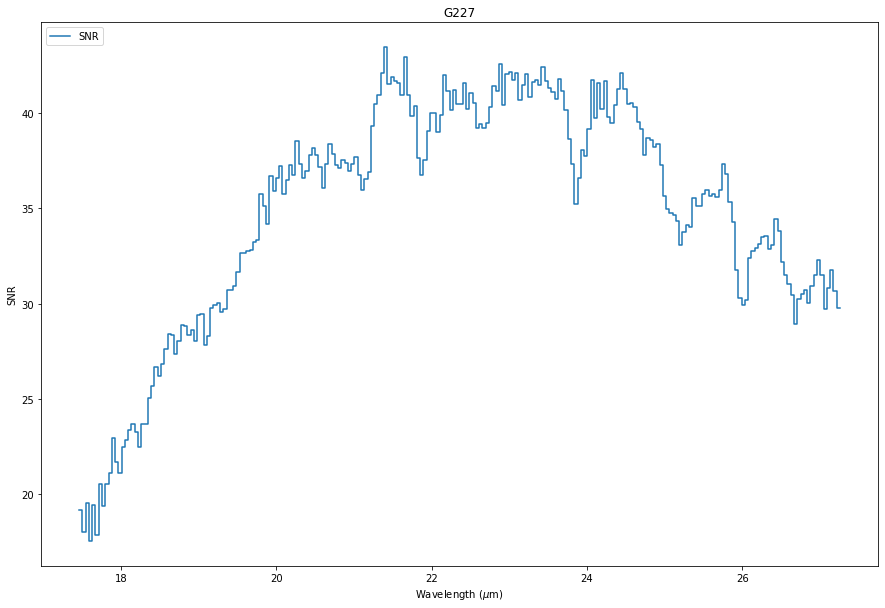

In [9]:
plt.figure(figsize=(15,10))
plt.step(g227['wavelength'], g227['flux']/g227['error'], label = 'SNR', where='mid')

plt.title("G227")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('SNR')
plt.legend(loc='upper left');

In order to assess whether any particular features in the spectrum are real or not, it is important to compare the flux to the telluric transmission.  We'll write a short function for comparing flux spectrum to telluric transmission from the same data table.

C:\Users\Steven\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


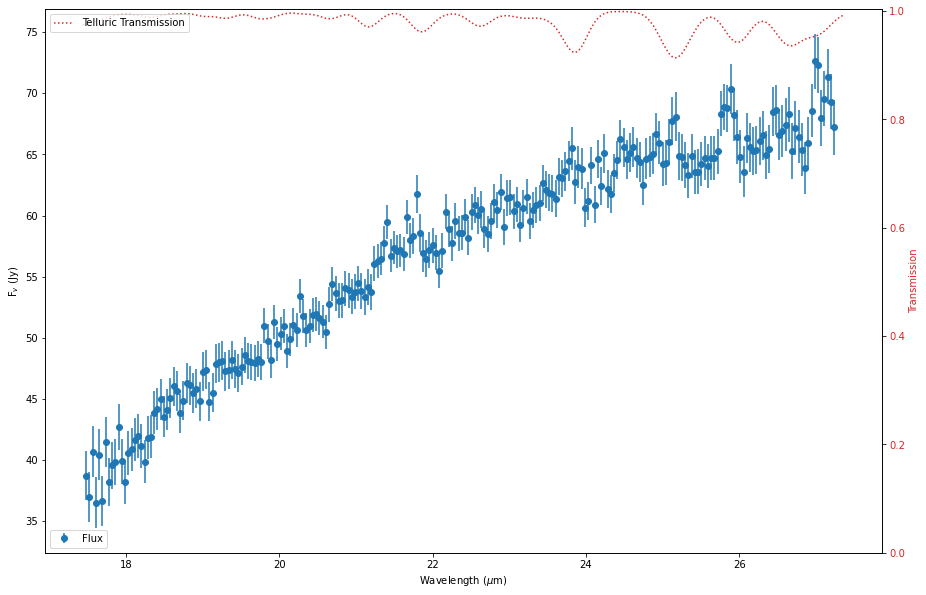

In [10]:
#Define a function to plot two spectra from the same FORCAST data table:
def compareTelluric(table):
    fig, ax1 = plt.subplots(figsize=(15,10))

    ax1.set_xlabel('Wavelength ($\mu$m)')
    ax1.set_ylabel('F$_v$ (Jy)')
    ax1.errorbar(table['wavelength'],table['flux'],yerr=table['error'],fmt='o', label = 'Flux')
    plt.legend(loc='lower left')

    color = 'tab:red'
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Transmission', color=color)
    ax2.plot(table['wavelength'],table['telluric'], color=color, linestyle=':', label = 'Telluric Transmission')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom=0.0)
    #plt.title(table)
    plt.legend(loc='upper left')

compareTelluric(g227)

It is clear form this plot that most of the "features" in the spectrum are in fact residuals left over from the telluric correction.  It is sometimes possible to improve the correction by careful modelling of the atmospheric lines, but some residuals are almost always present. 

For very low-S/N data, it is useful to look at both the telluric transmission and the response.  Here we'll take a look at the G329 grism data as an example:

C:\Users\Steven\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


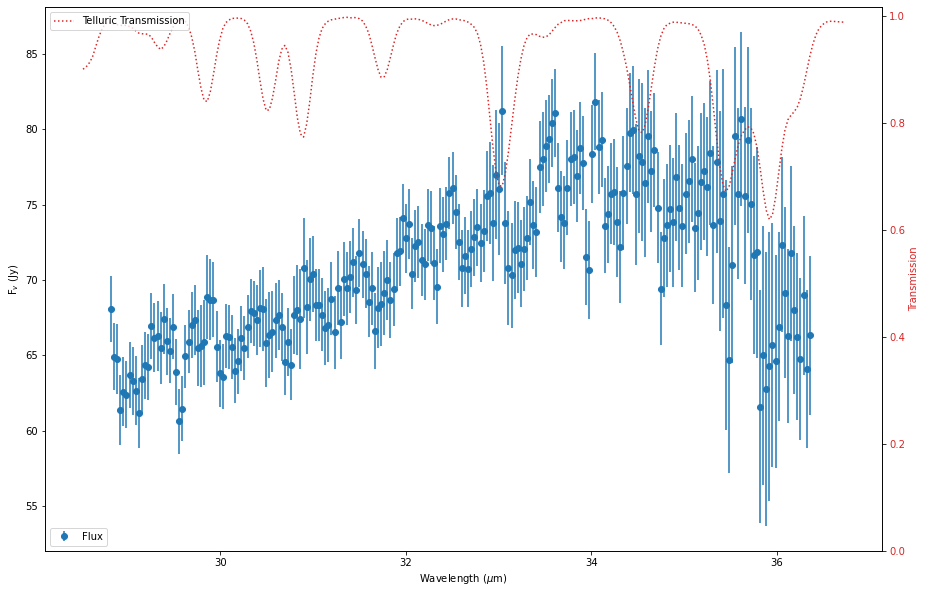

In [11]:
#Read in data for G329 grism using the function we defined earlier:
g329_fits,g329 = loadFORCASTGrismData('F0434_FO_GRI_0501384_FORG329_CMB_0239-0246.fits')


#now plot flux and telluric transmission together
compareTelluric(g329)

C:\Users\Steven\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'G329')

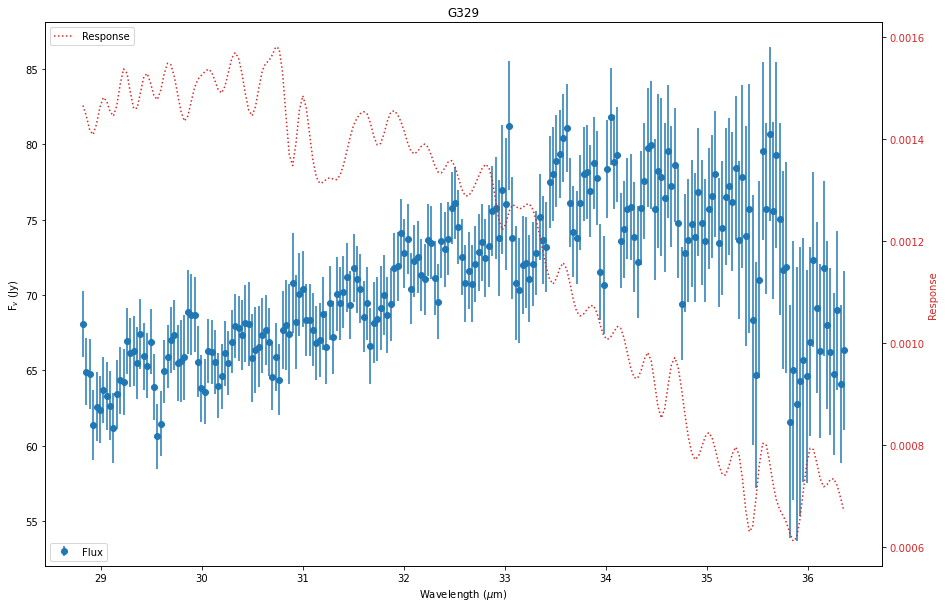

In [12]:
#and now plot flux and response  together
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g329['wavelength'],g329['flux'],yerr=g329['error'],fmt='o',label='Flux')
plt.legend(loc='lower left')

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Response', color=color)
ax2.plot(g329['wavelength'],g329['response'], color=color, linestyle=':',label='Response')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left')
plt.title('G329')


Due to the strong telluric absorption coupled with relatively low response, the flux values for $\lambda$ > 35 $\mu$m should be viewed with some caution.  

## Masking Regions with Strong Telluric Features

Regions with particularly strong telluric absorption generally suffer from very poor correction and should be masked out.  For example, the G111 grism generally suffers from poor correction at 9.6 $\mu$m due to the very deep telluric O3 band there:

C:\Users\Steven\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


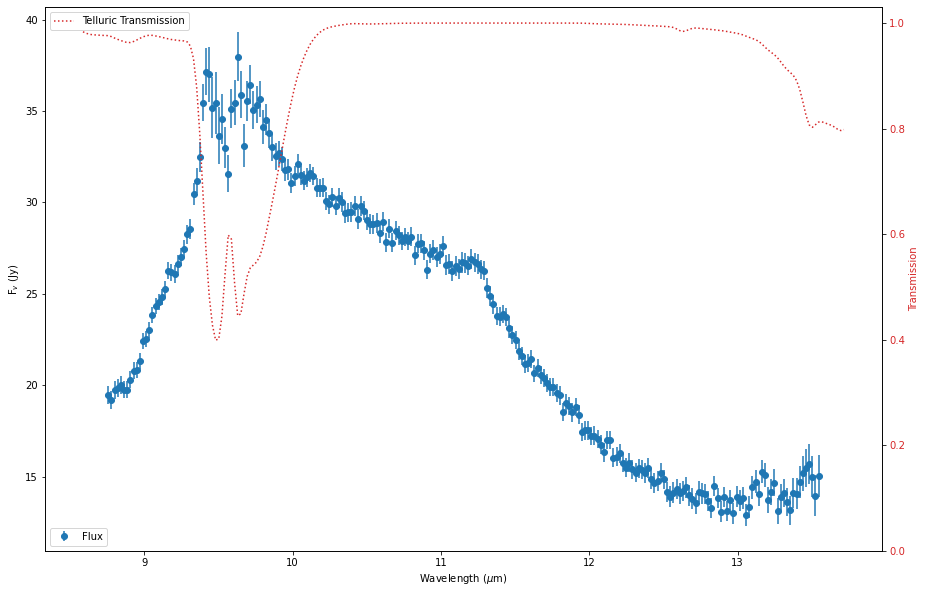

In [13]:
#Read in data for G111 grism using the function we defined earlier:
g111_fits,g111 = loadFORCASTGrismData('F0434_FO_GRI_0501382_FORG111_CMB_0234-0238.fits')

#and use our plotting function from earlier to compare flux to telluric transmission:
compareTelluric(g111)

Now mask out all flux values for which the transmission is less than some threshold (0.7 in this example) and re-plot.  Note that matplot lib automatically applies the mask to the data when plotting.  

C:\Users\Steven\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


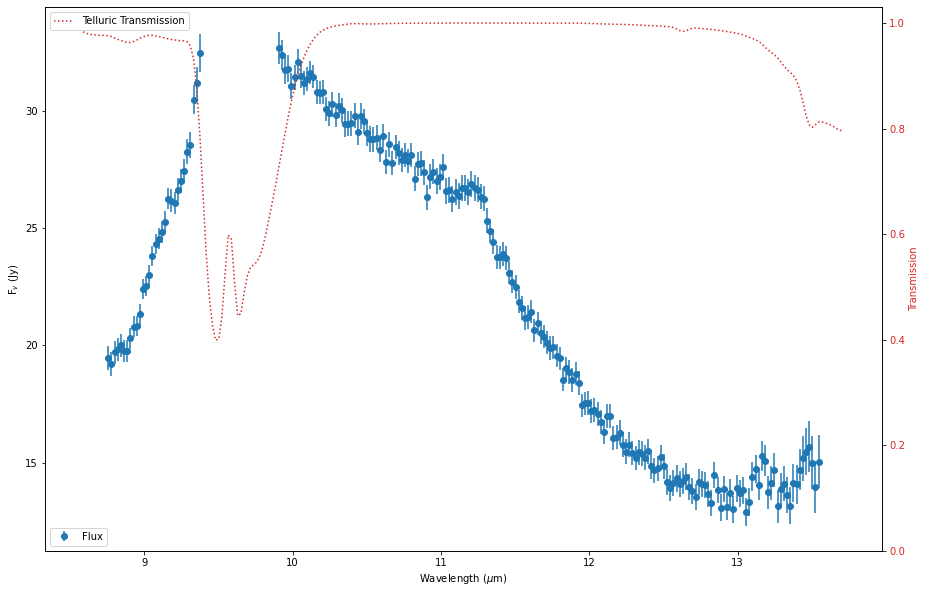

In [14]:
#Pick masking threshold for telluric transmission:
thresh = 0.7

#and generate masks for flux and error columns.
g111['flux'].mask  = g111['telluric'] < thresh
g111['error'].mask = g111['telluric'] < thresh

#Re-plot; masks are applied automatically.
compareTelluric(g111)

## Plotting the Complete SED

Now we can load the last grism data file (G063) and plot the full SED from 5 -- 40 mic.:

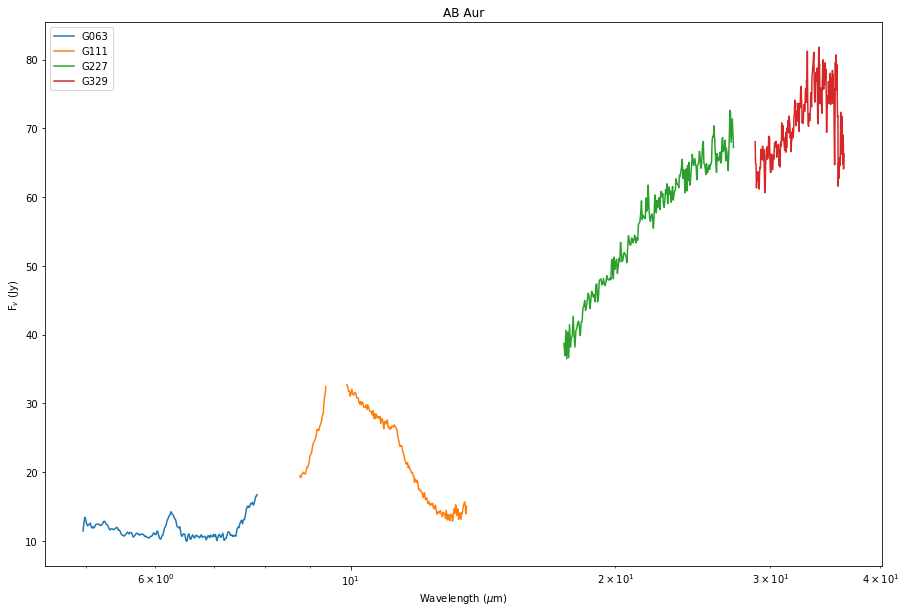

In [15]:
#And finally, read in the G063 data:

g063_fits,g063 = loadFORCASTGrismData('F0434_FO_GRI_0501381_FORG063_CMB_0228-0229.fits')

#Now plot all grism data together as a line plot, semi-log
plt.figure(figsize=(15,10))
plt.semilogx(g063['wavelength'], g063['flux'], label='G063')
plt.semilogx(g111['wavelength'], g111['flux'], label='G111')
plt.semilogx(g227['wavelength'], g227['flux'], label='G227')
plt.semilogx(g329['wavelength'], g329['flux'], label='G329')

plt.title("AB Aur")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend();

(Notice that Python automatically uses the masked data for G111.)

The first thing we notice is that there appears to be a flux break or discrepancy between the G227 and G329 grisms, which is most likely due to additional slit losses for the G329 data.

## Calibration Using Independant Photometry

The absolute flux calibration accuracy of the grism data can be uncertain by >10% due to systematic uncertainties at the time of observation (e.g. poor atmospheric conditions, bad seeing, or slit mis-alignment).  In this section, we show how to use independant FORCAST photometric observations to "re-calibrate" the grism data (assuming the imaging observations are considered accurate).

The most common reason for systematic error in the grism flux data is mis-alignment of the slit during the observation.  Since the width of the FORCAST slits are smaller than the SOFIA PSF in general, the slit only "samples" a fraction of the flux from the source.  The FORCAST pipeline accounts for this "loss" automatically for each grism using a default PSF model.  However, if the target is not centered on the slit during the observation, or if the image quality is poor, there can be an additional loss that is *not* accounted for in the pipeline processing.  These additional "slit losses" can be assessed and "fixed" using trusted absolute photometry from the same spectral region.  For the sample data, we also have photometric fluxes for each grism band pass which we use to compare to the grism spectra below.

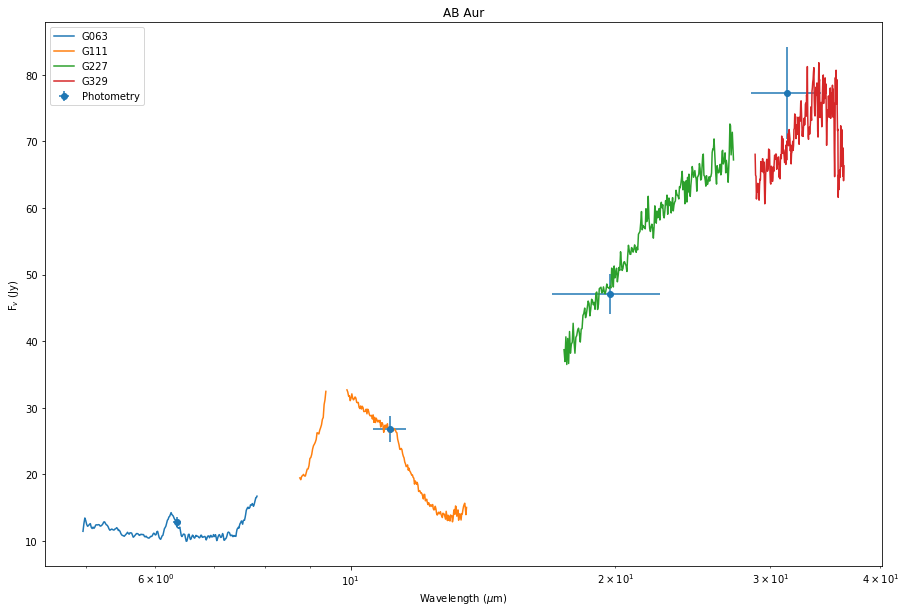

In [16]:
#Create a table of values for the photometry
filters = ['F064','F111','F197','F315']
waves = [6.34774,11.0888,19.6993,31.3615] #microns
delwaves = [0.14,0.95,5.5,5.7]  #filter bandpass (FWHM, microns)
fluxes = [12.854,26.778,47.129,77.264]  #Jy
relerrs = [0.063705,0.073197,0.063439,0.089142] #absolute uncertainty (ratio)


phot = Table([filters,waves,fluxes,relerrs,delwaves], 
                  names=('filter', 'wave', 'flux', 'relerr', 'delwave'),
                  meta={'name': 'Photometry Data Table'})

phot['wave'].unit = 'micron'
phot['delwave'].unit = 'micron'
phot['flux'].unit = 'Jy'

#Now plot all grism data together as a line plot, using semi-log (x-axis)
fp='tab:blue'
plt.figure(figsize=(15,10))
plt.semilogx(g063['wavelength'], g063['flux'], label='G063')
plt.semilogx(g111['wavelength'], g111['flux'], label='G111')
plt.semilogx(g227['wavelength'], g227['flux'], label='G227')
plt.semilogx(g329['wavelength'], g329['flux'], label='G329')


plt.errorbar(phot['wave'],phot['flux'],xerr=0.5*phot['delwave'],yerr=phot['flux']*phot['relerr'],
             fmt='o', color=fp, label = 'Photometry')

plt.title("AB Aur")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend();


The grism spectra match up very well with the photometry *except* for G329 which appears too low, most likely due to slit misalignment during the observation.  Assuming the losses are independant of wavelength, the grism data can be shifted up to match the photometric value by simply averaging the grism data (weighted by the filter transmission), calculating the offset between the average grism flux and the photometric flux, and applying that offset to the grism flux data.  Filter transmission curves can be found in the FORCAST Observers Handbook, which is available from the [SOFIA Proposal Resources](https://www.sofia.usra.edu/node/1454) page.

C:\Users\Steven\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


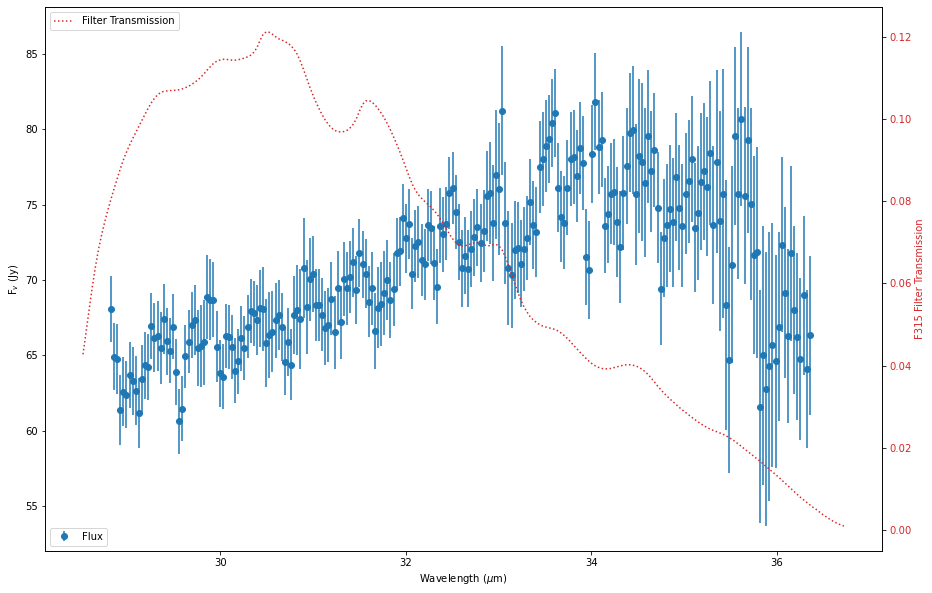

In [17]:
import numpy as np
import numpy.ma as ma

#read in filter transmission file from SOFIA website.
f315 = Table.read('https://www.sofia.usra.edu/sites/default/files/31pt5mu.txt', 
                  format='ascii', names=('wave', 'trans'))


#re-bin transmission onto our grism data wavelength grid and save in new array.
f315_wts = np.interp(g329['wavelength'],f315['wave'],f315['trans'])

#and now plot flux and response  together
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g329['wavelength'],g329['flux'],yerr=g329['error'],fmt='o',label='Flux')
plt.legend(loc='lower left')

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('F315 Filter Transmission', color=color)
ax2.plot(g329['wavelength'],f315_wts, color=color, linestyle=':',label='Filter Transmission')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left');


In [18]:
#now compute weighted average using the filter transmission for the weights.
g329_av = ma.average(g329['flux'],weights=f315_wts)

#and shift the spectrum up by the difference
g329_f_adj = g329['flux'] + (phot['flux'][3] - g329_av)

#and add to the data table
g329['flux_adj'] = g329_f_adj
g329['flux_adj'].unit = 'Jy'

Here we've added an extra column for the new "adjusted" flux spectrum.  Now re-plot with the adjusted values for G329: 

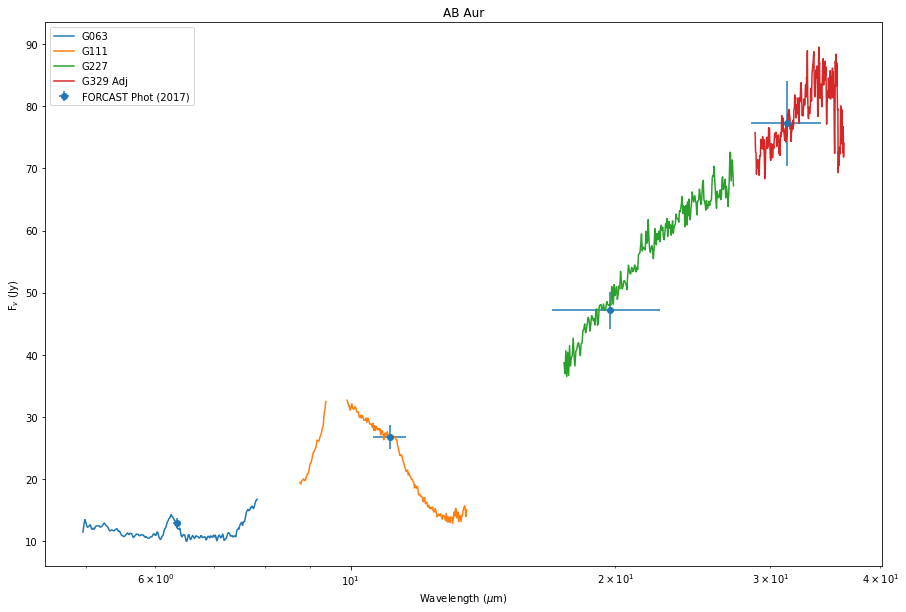

In [19]:
fp='tab:blue'
plt.figure(figsize=(15,10))

# plot all grism settings
plt.semilogx(g063['wavelength'], g063['flux'], label='G063')
plt.semilogx(g111['wavelength'], g111['flux'], label='G111')
plt.semilogx(g227['wavelength'], g227['flux'], label='G227')

# plot adjusted spectrum for g329
plt.semilogx(g329['wavelength'], g329['flux_adj'], label='G329 Adj')  # <--- Adjusted spectrum

plt.errorbar(phot['wave'],phot['flux'],xerr=0.5*phot['delwave'],
             yerr=phot['flux']*phot['relerr'],
             fmt='o', color=fp, label = 'FORCAST Phot (2017)')

plt.title("AB Aur")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend();

The adjusted G329 spectrum now matches the G227 spectrum very nicely.  

USER EXERCISE:  Use the F197 photometry and filter curve to re-calibrate the G227 grism spectrum.  In this case, the overall grism flux should come *down* just a little.  

## Converting to $\lambda$F$_{\lambda}$

We often want to work with $\lambda$F$_{\lambda}$ in order to assess where the object is emitting the most power (per logade or decade).  AstroPy quantities and constants makes this easy.  Remember that $\lambda$F$_{\lambda}$ = $v$F$_v$ = c * F$_v$ / $\lambda$.


In [20]:
#Calculate lam f_lam (= nu F_nu = c * F_nu / lambda), convert to W/m^2, and add to table with mask if it exists.

lamflam=const.c * g063['flux']/g063['wavelength']  #calculate 
lamflam=lamflam.to(u.W / (u.m * u.m))  #and convert to W/m^2
g063['lamflam'] = lamflam  #...put in table...

lamflam=const.c * g111['flux']/g111['wavelength']  #calculate 
lamflam=lamflam.to(u.W / (u.m * u.m))  #and convert to W/m^2
g111['lamflam'] = lamflam  #...put in table...
g111['lamflam'].mask = g111['flux'].mask  #...and dont forget to mask lamflam as well.

lamflam=const.c * g227['flux']/g227['wavelength']  #calculate 
lamflam=lamflam.to(u.W / (u.m * u.m))  #and convert to W/m^2
g227['lamflam'] = lamflam  #...put in table...

lamflam=const.c * g329['flux_adj']/g329['wavelength']  #calculate using adjusted flux
lamflam=lamflam.to(u.W / (u.m * u.m))  #and convert to W/m^2
g329['lamflam'] = lamflam  #...put in table...

g111.info

<Table masked=True length=242>
   name     dtype     unit    n_bad
---------- ------- ---------- -----
wavelength float64     micron     0
      flux float64         Jy    24
     error float64         Jy    24
  telluric float64                0
  response float64 1 / (Jy s)     0
   lamflam float64     W / m2    24

We've retained MKS units, but it is easy to convert to CGS from here if desired.

And now re-plot with $\lambda$F$_{\lambda}$:

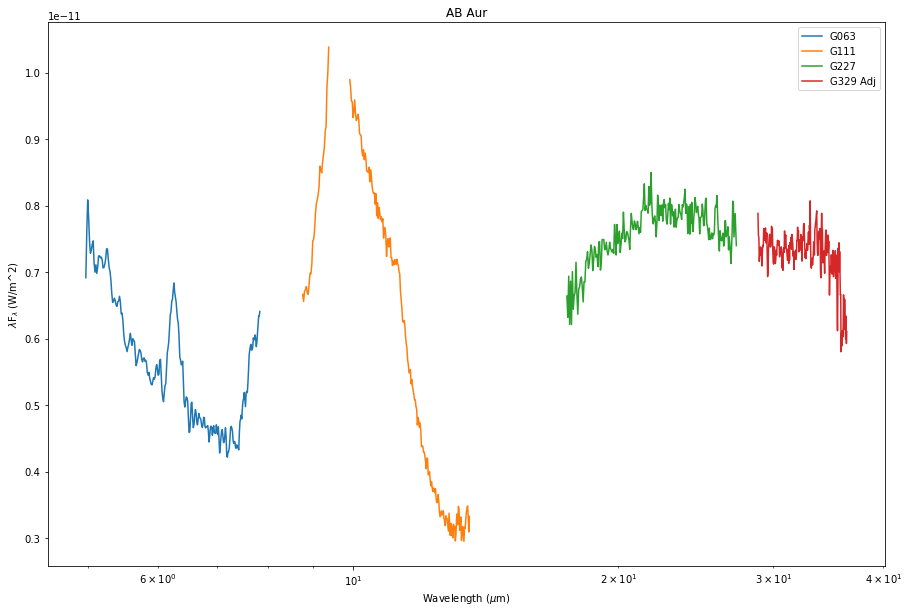

In [21]:
fp='tab:blue'
plt.figure(figsize=(15,10))

# plot all grism settings
plt.semilogx(g063['wavelength'], g063['lamflam'], label='G063')
plt.semilogx(g111['wavelength'], g111['lamflam'], label='G111')
plt.semilogx(g227['wavelength'], g227['lamflam'], label='G227')

# plot adjusted spectrum for g329
plt.semilogx(g329['wavelength'], g329['lamflam'], label='G329 Adj')  # <--- Adjusted spectrum
    
plt.title("AB Aur")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('$\lambda$F$_{\lambda}$ (W/m^2)')
plt.legend();